# EX4 Solution

#### import all packages :

In [398]:
% pylab inline
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

Populating the interactive namespace from numpy and matplotlib


C:\Users\oleg\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['table']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## data import

In [399]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")

## cheking & filling missing values

In [400]:
df_train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [401]:
df_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [402]:
missing_values=pd.DataFrame(data=[df_train.apply(lambda x: sum(x.isnull()),axis=0),df_train.apply(lambda x: x.count())],
             columns=df_train.columns,index=['null count','total count'])
print(missing_values.apply(lambda x: sum(x>0),axis=1))
missing_values


null count      7
total count    13
dtype: int64


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
null count,0,13,3,15,0,32,0,0,22,14,50,0,0
total count,614,601,611,599,614,582,614,614,592,600,564,614,614


we can see that in total the num of missing values is small, so in most columns we will just fill the missing values with the value that appears more often.

In [403]:
df_train['Self_Employed'].fillna('No',inplace=True)
df_train['Loan_Amount_Term'].fillna(360, inplace=True)
df_train['Credit_History'].fillna(1, inplace=True)
df_train['Dependents'].fillna(0, inplace=True)
df_train['Married'].fillna('Yes', inplace=True)
df_train['Gender'].fillna('Male', inplace=True)

In [404]:
df_test['Self_Employed'].fillna('No',inplace=True)
df_test['Loan_Amount_Term'].fillna(360, inplace=True)
df_test['Credit_History'].fillna(1, inplace=True)
df_test['Dependents'].fillna(0, inplace=True)
df_test['Married'].fillna('Yes', inplace=True)
df_test['Gender'].fillna('Male', inplace=True)

in LoadAmount column we will calculate the median for each of the combinations in 'Self_Employed' and 'Education' columns and fill the LoanAmount accordingly.

In [405]:
table = df_train.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)
values_to_fill_LA=df_train[df_train['LoanAmount'].isnull()].apply(lambda x: table.loc[x['Self_Employed'],x['Education']], axis=1)
df_train['LoanAmount'].fillna(values_to_fill_LA, inplace=True)

In [406]:
table = df_test.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)
values_to_fill_LA=df_test[df_test['LoanAmount'].isnull()].apply(lambda x: table.loc[x['Self_Employed'],x['Education']], axis=1)
df_test['LoanAmount'].fillna(values_to_fill_LA, inplace=True)


## convert all our categorical variables into numeric

In [407]:
df_train.dtypes 

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [408]:
var_mod = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']
le = LabelEncoder()
for i in var_mod:
    df_train[i] = le.fit_transform(df_train[i].astype(str))
    

do the same for test set

In [409]:
var_mod = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area']
le = LabelEncoder()
for i in var_mod:
    df_test[i] = le.fit_transform(df_test[i].astype(str))
    

## now we will normalize,analyze and manipulate the data for best prediction scores

normalizing the LoanAmount column

In [410]:
df_train['LoanAmount_log'] = np.log(df_train['LoanAmount'])

df_test['LoanAmount_log'] = np.log(df_test['LoanAmount'])


we will add a column TotalIncome and normalize it by log in column TotalIncome_log

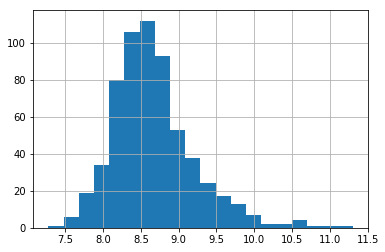

In [411]:
df_train['TotalIncome'] = df_train['ApplicantIncome'] + df_train['CoapplicantIncome']
df_train['TotalIncome_log'] = np.log(df_train['TotalIncome'])
df_train['TotalIncome_log'].hist(bins=20) 

df_test['TotalIncome'] = df_test['ApplicantIncome'] + df_test['CoapplicantIncome']
df_test['TotalIncome_log'] = np.log(df_test['TotalIncome'])

another column we like to add is LoanAmount/TotalIncome cause it gives as a clue about the capability of the applicant to return the loan.

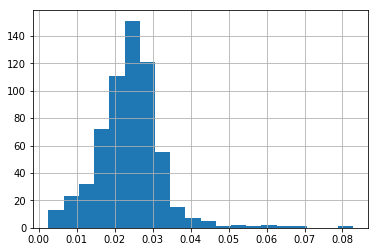

In [412]:
df_train['returnCapability'] = df_train['LoanAmount']/df_train['TotalIncome']
df_train['returnCapability'].hist(bins=20) 

### we will check the realations between our target column and all other columns

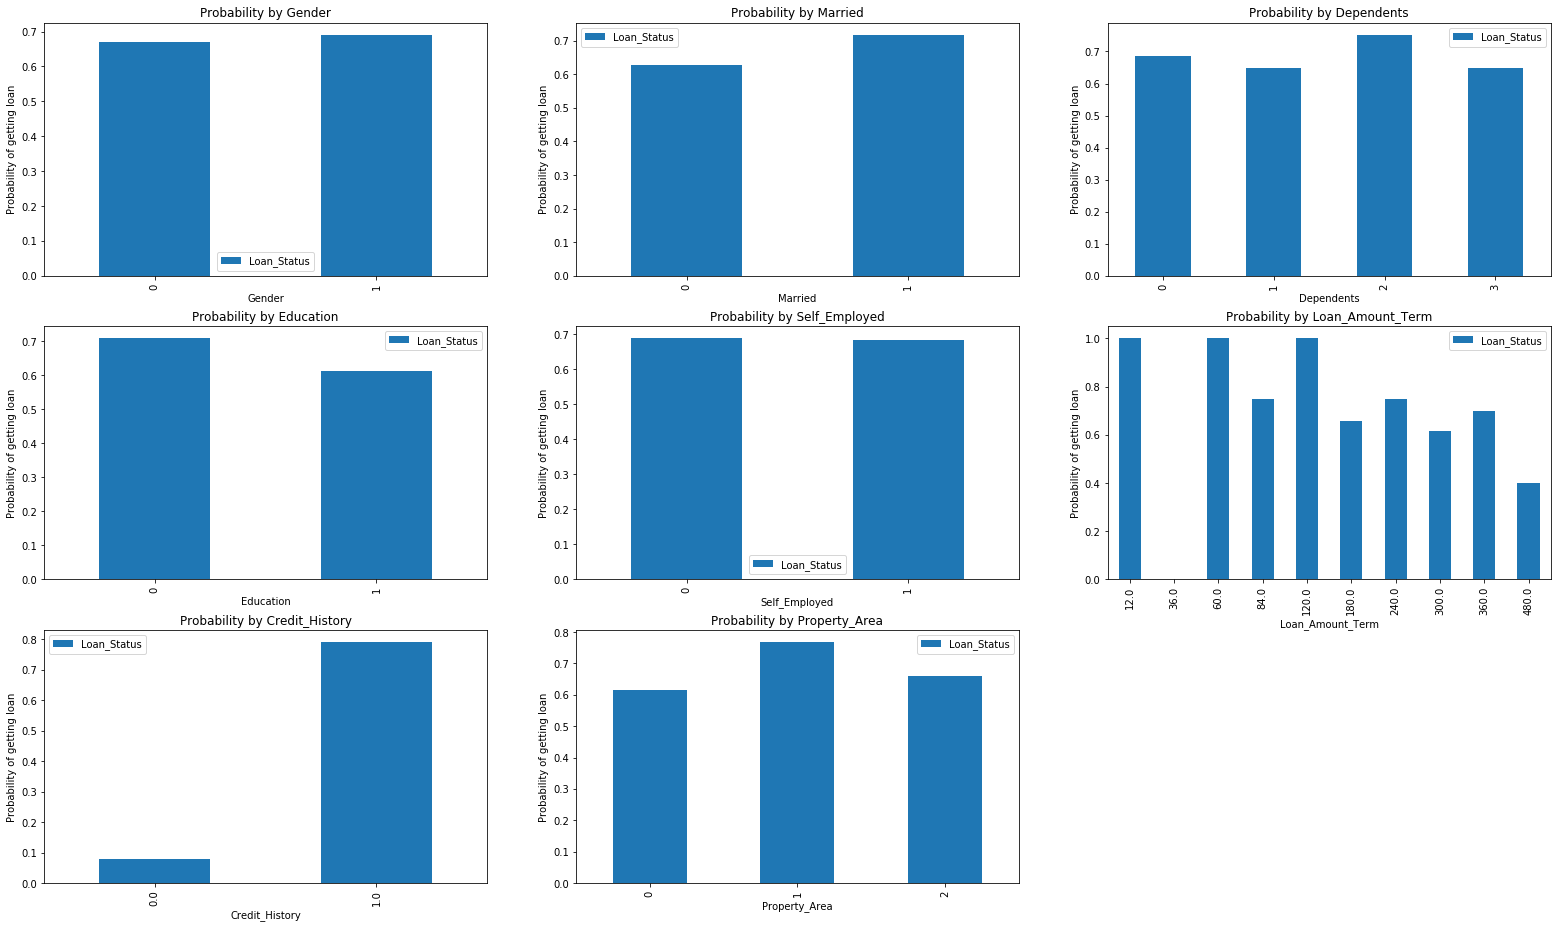

In [413]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(27,27))

features=['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed','Loan_Amount_Term', 'Credit_History', 'Property_Area']
for i,feature in enumerate(features):
    temp = df_train.pivot_table(values='Loan_Status',index=[feature],aggfunc=lambda x: x.mean())
    ax = fig.add_subplot(5,3,i+1) # 1x2 grid on the first subplot
    ax.set_xlabel(feature)
    ax.set_ylabel('Probability of getting loan')
    ax.set_title("Probability by %s" % feature)
    temp.plot(kind='bar',ax=ax)



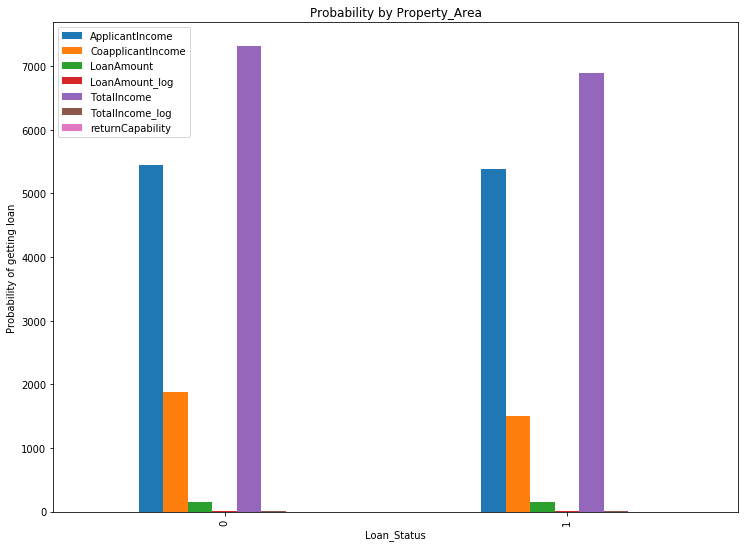

In [414]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(27,9))
features=['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount','TotalIncome', 
         'TotalIncome_log', 'returnCapability','LoanAmount_log']
# for i,feature in enumerate(features):
#     temp = df_train.pivot_table(values=feature,index=['Loan_Status'])
#     ax = fig.add_subplot(5,3,i+1) # 1x2 grid on the first subplot
#     ax.set_xlabel(feature)
#     ax.set_ylabel('Probability of getting loan')
#     ax.set_title("Probability by %s" % feature)
#     temp.plot(kind='bar',ax=ax)

temp = df_train.pivot_table(values=features,index=['Loan_Status'])
ax = fig.add_subplot(1,2,1) # 1x2 grid on the first subplot
ax.set_xlabel(feature)
ax.set_ylabel('Probability of getting loan')
ax.set_title("Probability by %s" % feature)
temp.plot(kind='bar',ax=ax)

## building the predictive model

the next function gets an array of models and list of predictors and prints the accuracy and Cross-Validation Score 
for every combination of model and predictor list.

In [415]:
def classification_model(modelList, data, predictorsList, outcome):
    ans=[]
    for i,model in enumerate(modelList):
        print("Model : ", i+1)
        resList=[]
        for index,predictors in enumerate(predictorsList):
            accuracyAndCV=""
            print("\tchecking for predictors : ",index+1)
            #Fit the model:
            model.fit(data[predictors],data[outcome])

            #Make predictions on training set:
            predictions = model.predict(data[predictors])

            #Print accuracy
            accuracy = metrics.accuracy_score(predictions,data[outcome])
            accuracyAndCV+="Accuracy: "
            accuracyAndCV+=str("{0:.3%}".format(accuracy))
            #print("\tAccuracy : %s" % "{0:.3%}".format(accuracy))
            
            #Perform k-fold cross-validation with 5 folds
            kf = KFold(data.shape[0], n_folds=5)
            error = []
            for train, test in kf:
                # Filter training data
                train_predictors = (data[predictors].iloc[train,:])

                # The target we're using to train the algorithm.
                train_target = data[outcome].iloc[train]

                # Training the algorithm using the predictors and target.
                model.fit(train_predictors, train_target)

                #Record error from each cross-validation run
                error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))

            #print("\tCross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))
            accuracyAndCV+=" CV: "
            accuracyAndCV+=str("{0:.3%}".format(np.mean(error)))
            resList.append(accuracyAndCV)
            #print()
        ans.append(resList)
    return ans
        

In [416]:
allvars=['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area','TotalIncome', 
         'TotalIncome_log', 'returnCapability','LoanAmount_log']

### cheking feature importance

In [417]:
DTmodel=DecisionTreeClassifier()
RFmodel = RandomForestClassifier(n_estimators=1000)

DTmodel.fit(df_train[allvars],df_train[outcome_var])
RFmodel.fit(df_train[allvars],df_train[outcome_var])

featimp1 = pd.Series(DTmodel.feature_importances_, index=allvars).sort_values(ascending=False)
featimp2 = pd.Series(RFmodel.feature_importances_, index=allvars).sort_values(ascending=False)
print(featimp1)
print(featimp2)


Credit_History       0.292201
ApplicantIncome      0.156161
returnCapability     0.118644
TotalIncome          0.082630
CoapplicantIncome    0.063993
TotalIncome_log      0.053880
Dependents           0.047567
LoanAmount_log       0.044867
LoanAmount           0.039744
Property_Area        0.028626
Loan_Amount_Term     0.018535
Married              0.017714
Self_Employed        0.017172
Education            0.012203
Gender               0.006062
dtype: float64
Credit_History       0.244875
returnCapability     0.110894
TotalIncome_log      0.096910
TotalIncome          0.095863
ApplicantIncome      0.094320
LoanAmount           0.079891
LoanAmount_log       0.078392
CoapplicantIncome    0.060914
Property_Area        0.030750
Dependents           0.027669
Loan_Amount_Term     0.025564
Married              0.016277
Education            0.014763
Gender               0.011855
Self_Employed        0.011064
dtype: float64


combining the plots information and the feature importance we will build some group of features and check them all for some different models

In [418]:
outcome_var = 'Loan_Status'
predictor_var1 = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
        'LoanAmount_log','TotalIncome_log']
predictor_var2 = ['Credit_History', 'TotalIncome_log', 'LoanAmount_log','Property_Area','Dependents']
predictor_var3 = ['Credit_History', 'TotalIncome_log', 'LoanAmount_log','Property_Area','Education']
predictor_var4 = ['Credit_History', 'TotalIncome_log', 'LoanAmount_log','Property_Area']
predictor_var5 = ['Credit_History', 'TotalIncome_log', 'LoanAmount_log']
predictor_var6 = ['Credit_History', 'TotalIncome_log', 'LoanAmount_log','Married','Dependents']
predictor_var7 = ['Credit_History','ApplicantIncome','returnCapability']
predictorsList=[predictor_var1,predictor_var2,predictor_var3,predictor_var4,predictor_var5,predictor_var6,predictor_var7]

In [419]:
model1=SVC(gamma=2, C=1)
model2=SVC(kernel="linear", C=0.025)
model3=GaussianNB()
model4=KNeighborsClassifier(20)
modelsList=[model1,model2,model3,model4]

In [420]:
modelsList=[model1,model2,model3,model4]
a=classification_model(modelsList, df_train,predictorsList,outcome_var)

Model :  1
	checking for predictors :  1
	checking for predictors :  2
	checking for predictors :  3
	checking for predictors :  4
	checking for predictors :  5
	checking for predictors :  6
	checking for predictors :  7
Model :  2
	checking for predictors :  1
	checking for predictors :  2
	checking for predictors :  3
	checking for predictors :  4
	checking for predictors :  5
	checking for predictors :  6
	checking for predictors :  7
Model :  3
	checking for predictors :  1
	checking for predictors :  2
	checking for predictors :  3
	checking for predictors :  4
	checking for predictors :  5
	checking for predictors :  6
	checking for predictors :  7
Model :  4
	checking for predictors :  1
	checking for predictors :  2
	checking for predictors :  3
	checking for predictors :  4
	checking for predictors :  5
	checking for predictors :  6
	checking for predictors :  7


In [421]:
pd.DataFrame(data=a,
             columns=['pred1','pred2','pred3','pred4','pred5','pred6','pred7'],
             index=['SVC1','SVC2','GaussianNB','KNeighbors'])

,pred1,pred2,pred3,pred4,pred5,pred6,pred7
SVC1,Accuracy: 90.879% CV: 75.898%,Accuracy: 84.365% CV: 79.158%,Accuracy: 82.410% CV: 79.968%,Accuracy: 82.248% CV: 80.131%,Accuracy: 81.922% CV: 80.131%,Accuracy: 82.736% CV: 79.968%,Accuracy: 96.091% CV: 69.380%
SVC2,Accuracy: 80.945% CV: 80.946%,Accuracy: 80.945% CV: 80.946%,Accuracy: 80.945% CV: 80.946%,Accuracy: 80.945% CV: 80.946%,Accuracy: 80.945% CV: 80.946%,Accuracy: 80.945% CV: 80.946%,Accuracy: 80.945% CV: 80.784%
GaussianNB,Accuracy: 80.945% CV: 80.460%,Accuracy: 80.619% CV: 80.621%,Accuracy: 80.619% CV: 80.621%,Accuracy: 80.619% CV: 80.621%,Accuracy: 80.619% CV: 80.621%,Accuracy: 80.619% CV: 80.785%,Accuracy: 80.456% CV: 80.296%
KNeighbors,Accuracy: 76.221% CV: 72.798%,Accuracy: 80.293% CV: 78.988%,Accuracy: 80.782% CV: 80.620%,Accuracy: 80.782% CV: 80.946%,Accuracy: 81.107% CV: 80.620%,Accuracy: 80.293% CV: 79.479%,Accuracy: 70.358% CV: 66.939%


we can that we got the best results and accuracy-CV relation for (SVC2,pred4) and (KNeighbors,pred4) so thos are the results we going to upload to the competition.

import csv
from itertools import zip_longest

def intoCSV(list1,list2,filename):
    d = [list1, list2]
    export_data = zip_longest(*d, fillvalue = '')
    with open(filename, 'w', encoding="ISO-8859-1", newline='') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(("Loan_ID", "Loan_Status"))
        wr.writerows(export_data)
    myfile.close()

In [432]:
loadIdList=df_test['Loan_ID'].tolist()

def transformToYesNo(predictions):
    result=[]
    for i in predictions:
        if i==1:
            result.append('Y')
        else:
            result.append('N')
    return result

def getPred(model,pvars):
    model.fit(df_train[pvars],df_train[outcome_var])
    predictions = model.predict(df_test[pvars])
    predictions=transformToYesNo(predictions)
    return predictions

In [434]:
intoCSV(loadIdList,getPred(model2,predictor_var4),'ans1.csv')
intoCSV(loadIdList,getPred(model4,predictor_var4),'ans2.csv')
intoCSV(loadIdList,getPred(model1,predictor_var1),'ans3.csv')
intoCSV(loadIdList,getPred(model3,predictor_var1),'ans4.csv')

ans1 and ans2 are the best scores and those are the files we submited.

we also submited some other tries but they weren't successful as ans1 and ans2.